# Assignment 6
# Bayesian Inference Template 
## Machine Learning II
### Wali Ullah (09745)



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style(
    style="darkgrid", 
    rc={"axes.facecolor": ".9", "grid.color": ".8"}
)
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

import arviz as az
import patsy
import pymc3 as pm
from pymc3 import glm
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = [7, 6]
plt.rcParams["figure.dpi"] = 100

from sklearn.linear_model import LinearRegression
#import performance scores
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import seaborn as sns
import math
from math import *
#Stats Libraries
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import theano

# import scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving house_data.csv to house_data.csv


In [ ]:
import io
df =pd.read_csv(io.BytesIO(uploaded['house_data.csv']))
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
#!pip install pymc3

# Functions 

I have define two main functions:
1. Model Inference Using MCMC (HMC)
2. Model Inference using Variational Inference (mini-batch ADVI)

I use these two types of to estimate the parameters of Linear Regression Model through Bayesian approach. 

**First, I consider the whole sample and compare the fitting performance of these two setups.**

**Second, I use the training-test split to compare the predective performance of the two types of approaches.**




### Function for Spliting Data into Training and Test Sets

In [ ]:
def train_test(formula,df):
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    
#print(scaled)

    # Define model formula.
    formula = formula
    # Create features.
    y, x = patsy.dmatrices(formula_like=formula, data=df)
    y = np.asarray(y).flatten()
    labels = x.design_info.column_names
    x = np.asarray(x)
    x = scaler.fit_transform(x)
    #do a train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=SEED)
    return x,y,x_train, x_test, y_train, y_test, labels

# MCMC Model

In [ ]:
def MCMC_fit(formula,df,test,family,prior,prior_samples,
          draws, chains, tune, target_accept, SEED,verbose=0):
    
    x,y,x_train, x_test, y_train, y_test, labels=train_test(formula,df)
    if test=='yes':
        x=x_train
        y=y_train
    else:
        x=x
        y=y 
    
    with pm.Model() as linear_model:
    # Set data container.
        data = pm.Data("data", x)
    # Define GLM family.
        family =family#glm.families.Normal()# pm.glm.families.Binomial()
    # Set priors.
        priors = prior
    # Specify model.
        glm.GLM(y=y, x=data,family=family,intercept=False,labels=labels,priors=priors)
    # Sample from prior distribution.
    with linear_model:
        prior_checks = pm.sample_prior_predictive(samples=prior_samples, random_seed=SEED)
    with linear_model:
    # Configure sampler.
        trace_normal = pm.sample(draws=draws, chains=chains, tune=tune, target_accept=target_accept, random_seed=SEED)
    return linear_model, trace_normal, x,y,x_train, x_test, y_train, y_test
    


# Model Inference Using MCMC (HMC)


We will make use of the default MCMC method in PYMC3's `sample` function, which is Hamiltonian Monte Carlo (HMC). Briefly, MCMC algorithms work by defining multi-dimensional Markovian stochastic processes, that when simulated (using Monte Carlo methods), will eventually converge to a state where successive simulations will be equivalent to drawing random samples from the posterior distribution of the model we wish to estimate.

The posterior distribution has one dimension for each model parameter, so we can then use the distribution of samples for each parameter to infer the range of possible values and/or compute point estimates (e.g. by taking the mean of all samples).


In [ ]:
def NUTS_fit(formula,df,test,family,prior,prior_samples,
          draws, chains, tune, target_accept, SEED,verbose=0):
    model, trace_normal, x,y,x_train, x_test, y_train, y_test=MCMC_fit(formula,df,test,family,prior,prior_samples,
                                                                       draws, chains, tune, target_accept, SEED)
    if test=='yes':
        x=x_train
        y=y_train
    else:
        x=x
        y=y 
    
    # Plot chains.
    az.plot_trace(data=trace_normal);
    display(az.summary(trace_normal))
    print('======================================')
    print('Training Fit')
    pm.set_data({"data": x}, model=model)
    # Generate posterior samples.
    ppc_train = pm.sample_posterior_predictive(trace_normal, model=model, samples=1000)
    train_pred = ppc_train["y"].mean(axis=0)
    r2 = r2_score(y,train_pred, multioutput='variance_weighted')
    # Adjusted R-squared
    r2_adjusted = 1-(1-r2)*(x.shape[0]-1)/(x.shape[0]-x.shape[1]-1)
    #MAE
    mae = mean_absolute_error(y,train_pred)
    # MSE
    mse = mean_squared_error(y,train_pred)
    #RMSE
    rmse = math.sqrt(mse)
    #print('r2=',r2)
    #print('r2_adjusted',r2_adjusted)
    print('mae=',mae)
    print('mse=',mse)
    print('rmse=',rmse)
    pm.plot_posterior(trace_normal, figsize = (12, 10));#, text_size = 20);
    pm.forestplot(trace_normal);
    return model, trace_normal
    
def NUTS_forecast(formula,df,test,family,prior,prior_samples,
                  draws, chains, tune, target_accept, SEED,verbose=0):
    model, trace_normal, x,y,x_train, x_test, y_train, y_test=MCMC_fit(formula,df,test,family,prior,prior_samples,
                                                                       draws, chains, tune, target_accept, SEED,verbose=0)
    pm.set_data({"data": x_test}, model=model)
    # Generate posterior samples.
    ppc_test = pm.sample_posterior_predictive(trace_normal, model=model, samples=1000)
    # Compute the point prediction by taking the mean
    # and defining the category via a threshold.
    p_test_pred = ppc_test["y"].mean(axis=0)
    r2 = r2_score(y_test,p_test_pred, multioutput='variance_weighted')
    # Adjusted R-squared
    r2_adjusted = 1-(1-r2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)
    #MAE
    mae = mean_absolute_error(y_test,p_test_pred)
    # MSE
    mse = mean_squared_error(y_test,p_test_pred)
    #RMSE
    rmse = math.sqrt(mse)
    #print('r2=',r2)
    #print('r2_adjusted',r2_adjusted)
    print('mae=',mae)
    print('mse=',mse)
    print('rmse=',rmse)
    return model, trace_normal

# Model Inference using Variational Inference (mini-batch ADVI)


Variational Inference (VI) takes a completely different approach to inference. Briefly, VI is a name for a class of algorithms that seek to fit a chosen class of functions to approximate the posterior distribution, effectively turning inference into an optimisation problem. We are going to make use of PYMC3's Auto-Differentiation Variational Inference (ADVI) algorithm, which is capable of computing a VI for any differentiable posterior distribution (i.e. any model with continuous prior distributions). In order to achieve this very clever feat (the paper is well-worth a read), the algorithm first maps the posterior into a space where all prior distributions have the same support, such that they can be well approximated by fitting a spherical n-dimensional Gaussian distribution within this space - this is referred to as the 'Gaussian mean-field approximation'. Note, that due to the initial transformation, this is **not** the same as approximating the posterior distribution using an n-dimensional Normal distribution. 
The assumption of a spherical Gaussian distribution does, however, imply no dependency (i.e. zero correlations) between parameter distributions. One of the advantages of HMC over ADVI, is that these correlations, which can lead to under-estimated variances in the parameter distributions, are included. ADVI gives these up in the name of computational efficiency (i.e. speed and scale of data). We also take the opportunity to make use of PYMC3's ability to compute ADVI using 'batched' data, analogous to how Stochastic Gradient Descent (SGD) is used to optimise loss functions in deep-neural networks, which further facilitates model training at scale.

In [ ]:
def ADVI_fit(formula,df,test, family,prior,prior_samples, draws, chains, tune, target_accept, SEED):
    
    model_advi, trace_avdi, x,y,x_train, x_test, y_train, y_test=MCMC_fit(formula,df,test,family,prior,prior_samples,
                                                                                      draws, chains, tune, target_accept, SEED)
    if test=='yes':
        x=x_train
        y=y_train
    else:
        x=x
        y=y 
   ##################
    y_tensor = theano.shared(y.astype('float64'))
    x_tensor = theano.shared(x.astype('float64'))
    ###########
    map_tensor_batch = {y_tensor: pm.Minibatch(y, 100),
                    x_tensor: pm.Minibatch(x, 100),
                    }
   ########################################  
    with model_advi:
        advi_fit = pm.fit(method=pm.ADVI(), n=30000, more_replacements=map_tensor_batch)   
    # Configure sampler.
    trace_advi = advi_fit.sample(10000)
    pm.traceplot(trace_advi)
    pm.summary(trace_advi)
    # Plot chains.
    az.plot_trace(data=trace_advi);
    display(az.summary(trace_advi))
    
    
    print('======================================')
    print('Training Fit')
    pm.set_data({"data": x}, model=model_advi)
    # Generate posterior samples.
    ppc_train = pm.sample_posterior_predictive(trace_advi, model=model_advi, samples=1000)
    train_pred = ppc_train["y"].mean(axis=0)
    r2 = r2_score(y,train_pred, multioutput='variance_weighted')
    # Adjusted R-squared
    r2_adjusted = 1-(1-r2)*(x.shape[0]-1)/(x.shape[0]-x.shape[1]-1)
    #MAE
    mae = mean_absolute_error(y,train_pred)
    # MSE
    mse = mean_squared_error(y,train_pred)
    #RMSE
    rmse = math.sqrt(mse)
    #print('r2=',r2)
    #print('r2_adjusted',r2_adjusted)
    print('mae=',mae)
    print('mse=',mse)
    print('rmse=',rmse)
    pm.plot_posterior(trace_advi, figsize = (12, 10));#, text_size = 20);
    pm.forestplot(trace_advi);
    # Print out the mean variable weight from the trace
    return model_advi, trace_advi

def ADVI_forecast(formula,df,test,family,prior,prior_samples,
          draws, chains, tune, target_accept, SEED):
    model_advi, trace_avdi, x,y,x_train, x_test, y_train, y_test=MCMC_fit(formula,df,test,family,prior,prior_samples,
                                                                          draws, chains, tune, target_accept, SEED)
    ####################################
    if test=='yes':
        x=x_train
        y=y_train
    else:
        x=x
        y=y 
   ##################
    y_tensor = theano.shared(y.astype('float64'))
    x_tensor = theano.shared(x.astype('float64'))
    ###########
    map_tensor_batch = {y_tensor: pm.Minibatch(y, 100),
                    x_tensor: pm.Minibatch(x, 100),
                    }
   ########################################  
    with model_advi:
        advi_fit = pm.fit(method=pm.ADVI(), n=30000, more_replacements=map_tensor_batch)   
    # Configure sampler.
    trace_advi = advi_fit.sample(10000)
    ############################
    y_tensor_test= theano.shared(y_test.astype('float64'))
    x_tensor_test= theano.shared(x_test.astype('float64'))
    ##################################
    print('Forecasting')
    pm.set_data({"data": x_test}, model=model_advi)
    # Generate posterior samples.
    ppc_test = pm.sample_posterior_predictive(trace_advi, model=model_advi, samples=1000)

    # Compute the point prediction by taking the mean
    # and defining the category via a threshold.
    p_test_pred = ppc_test["y"].mean(axis=0)
    r2 = r2_score(y_test,p_test_pred, multioutput='variance_weighted')
    # Adjusted R-squared
    r2_adjusted = 1-(1-r2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)
    #MAE
    mae = mean_absolute_error(y_test,p_test_pred)
    # MSE
    mse = mean_squared_error(y_test,p_test_pred)
    #RMSE
    rmse = math.sqrt(mse)
    #print('r2=',r2)
    #print('r2_adjusted',r2_adjusted)
    print('mae=',mae)
    print('mse=',mse)
    print('rmse=',rmse)
    return model_advi, trace_advi

# Dataset

In [ ]:
SEED = 42
#df = df=pd.read_csv('C:\\Users\\waliullah\\Desktop\\MLii\\Assignment6\\house_data1.csv')

#df = df=pd.read_csv('C:\\Users\\waliullah\\Desktop\\Assignment6\\house_data.csv')


#load_data(FILE_NAME)
#df=pd.read_csv('C:\\Users\\waliullah\\Desktop\\MLii\\Assignment4\\pd_speech_features1.csv')
display(df.head())
print(df.shape)
print(df.dtypes)

#C:\Users\waliullah\Desktop\MLii\Assignment6

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


(20640, 9)
MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
Price         float64
dtype: object


Let us do some exploration of the data:

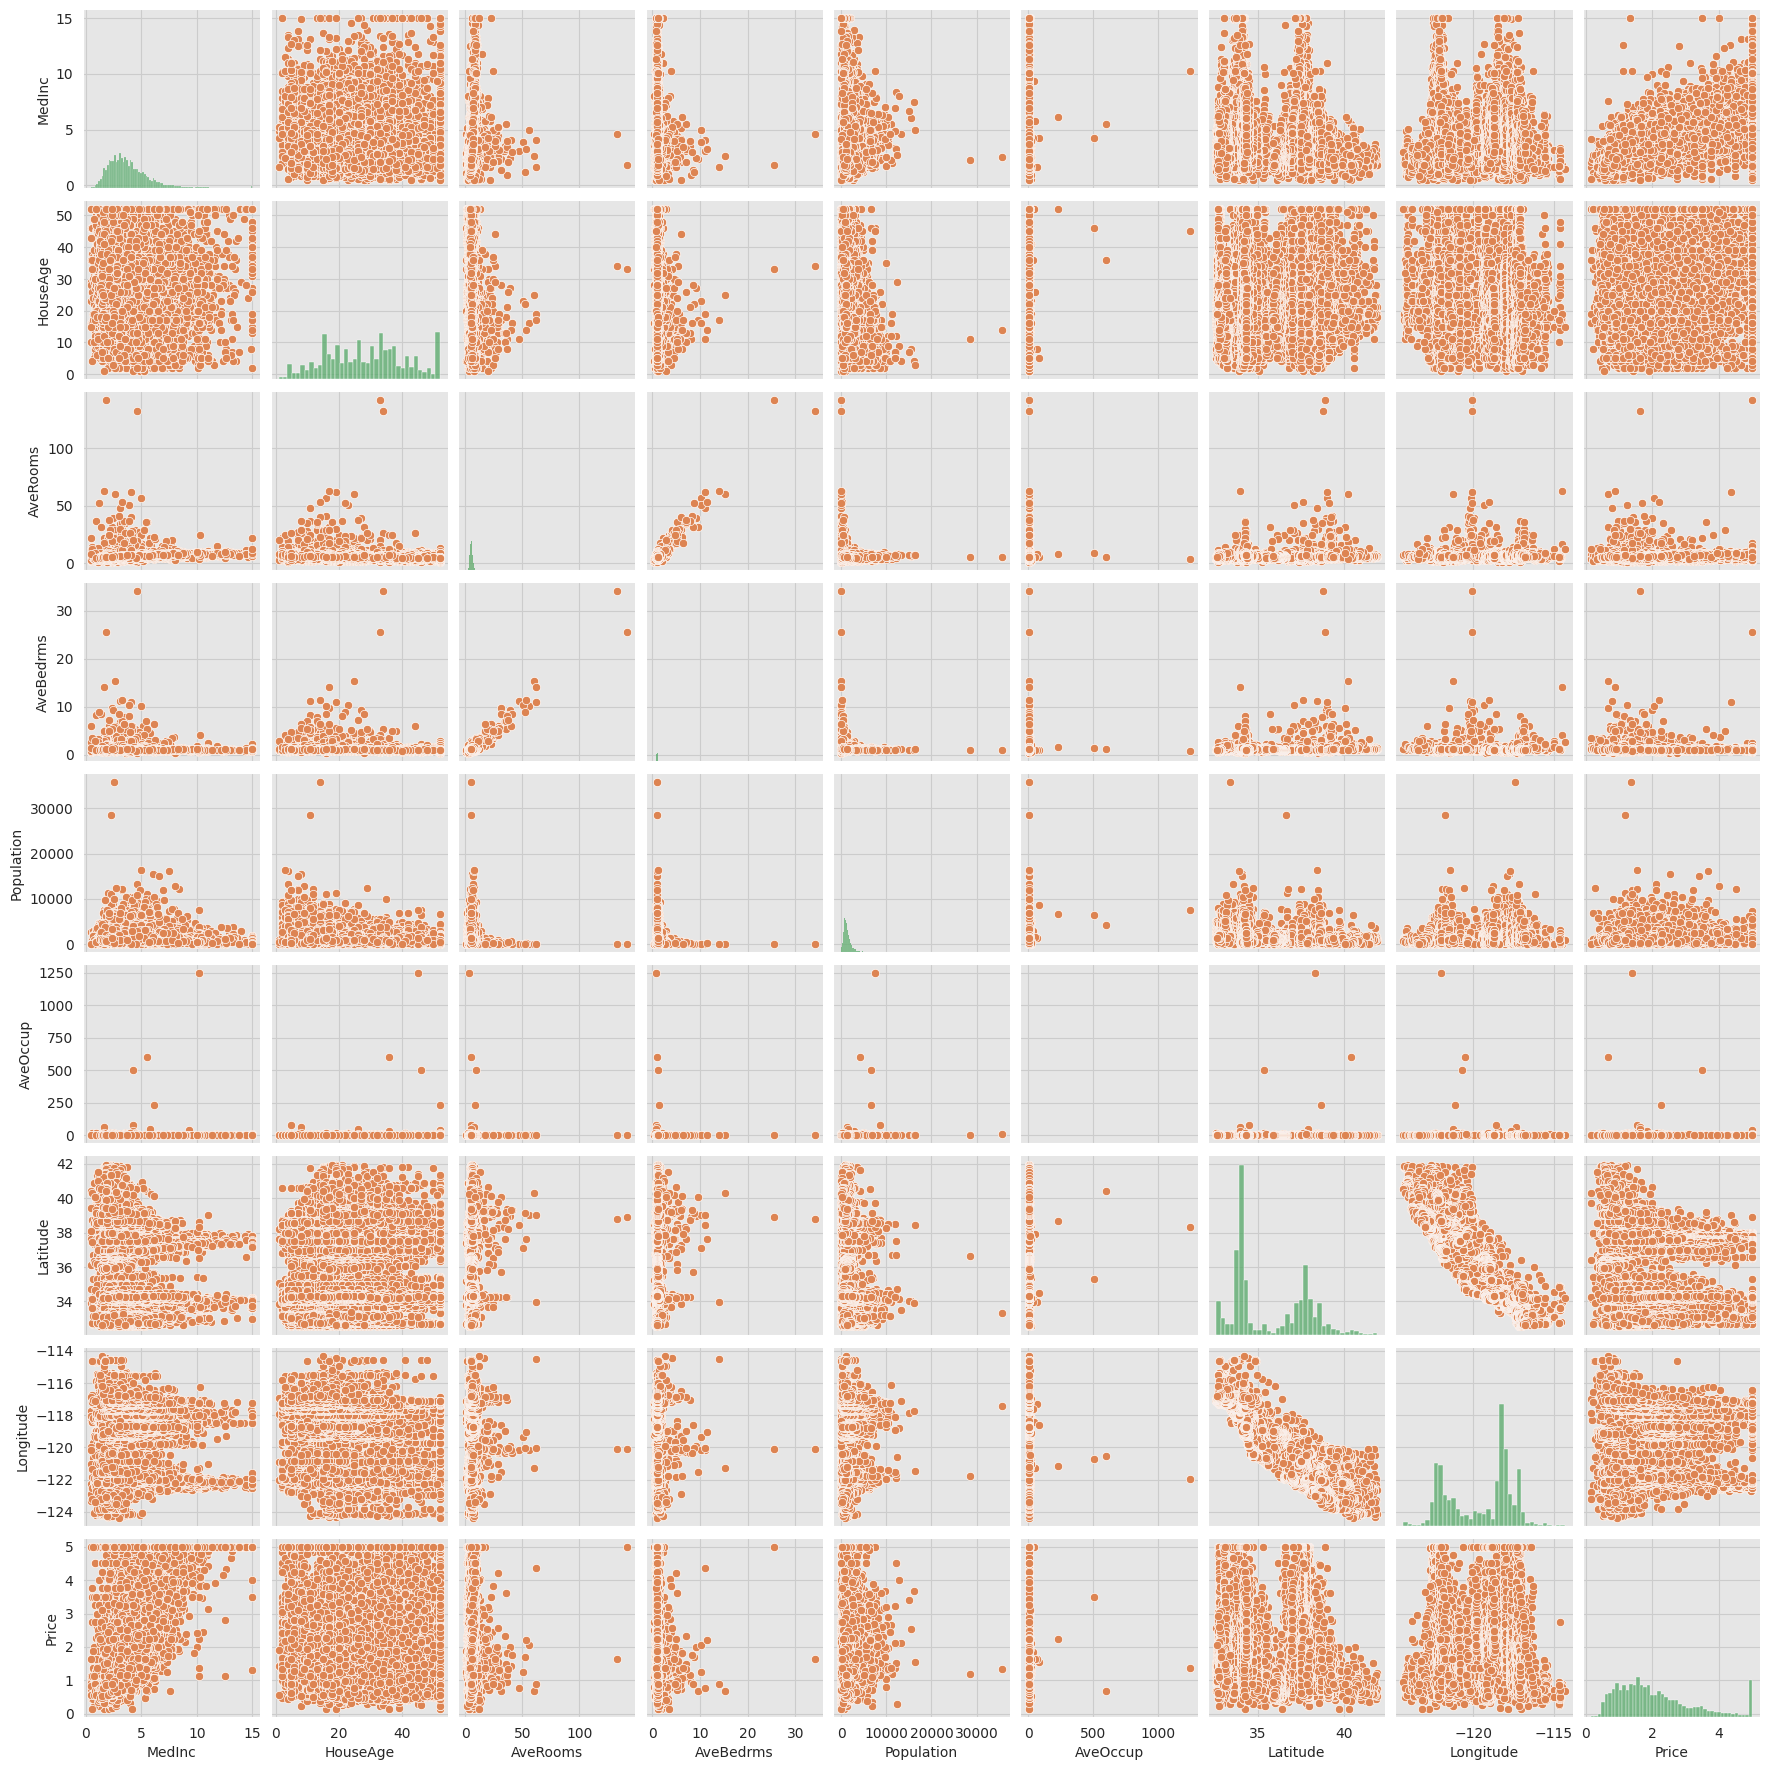

In [ ]:
sns.pairplot(
    data=df,
    kind="scatter",
    height=2,
    plot_kws={"color": sns_c[1]},
    diag_kws={"color": sns_c[2]}
);

In [ ]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Price'],
      dtype='object')

# Fitting the Models on Overall Data

## Model Inference Using MCMC (HMC)
For the purposes of this demonstration, we allow 1,000 steps for each chain to converge to its steady-state and then sample for a further 5,000 steps - i.e. generate 5,000 samples from the posterior distribution, assuming that the chain has converged after 1,000 samples.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (5 chains in 1 job)
NUTS: [sd, Longitude, Latitude, AveOccup, Population, AveBedrms, AveRooms, HouseAge, MedInc, Intercept]


Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 531 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.003,10.000,-19.212,18.365,0.057,0.068,30757.0,17529.0,1.0
MedInc,0.830,0.024,0.785,0.876,0.000,0.000,15206.0,17945.0,1.0
HouseAge,0.119,0.017,0.087,0.151,0.000,0.000,26730.0,19329.0,1.0
AveRooms,-0.266,0.044,-0.347,-0.180,0.000,0.000,14612.0,15425.0,1.0
AveBedrms,0.306,0.041,0.229,0.381,0.000,0.000,15565.0,16749.0,1.0
Population,-0.004,0.016,-0.034,0.026,0.000,0.000,27658.0,19102.0,1.0
AveOccup,-0.039,0.015,-0.068,-0.011,0.000,0.000,33326.0,19076.0,1.0
Latitude,-0.900,0.047,-0.987,-0.813,0.000,0.000,15725.0,16898.0,1.0
Longitude,-0.870,0.046,-0.956,-0.785,0.000,0.000,16142.0,17300.0,1.0
sd,2.192,0.011,2.172,2.212,0.000,0.000,30810.0,17195.0,1.0


Training Fit


Got error No model on context stack. trying to find log_likelihood in translation.


mae= 2.0704017464747406
mse= 4.806544523776324
rmse= 2.1923832976412507


Got error No model on context stack. trying to find log_likelihood in translation.


(<pymc3.model.Model at 0x7fb324620c90>,
 <MultiTrace: 5 chains, 5000 iterations, 11 variables>)

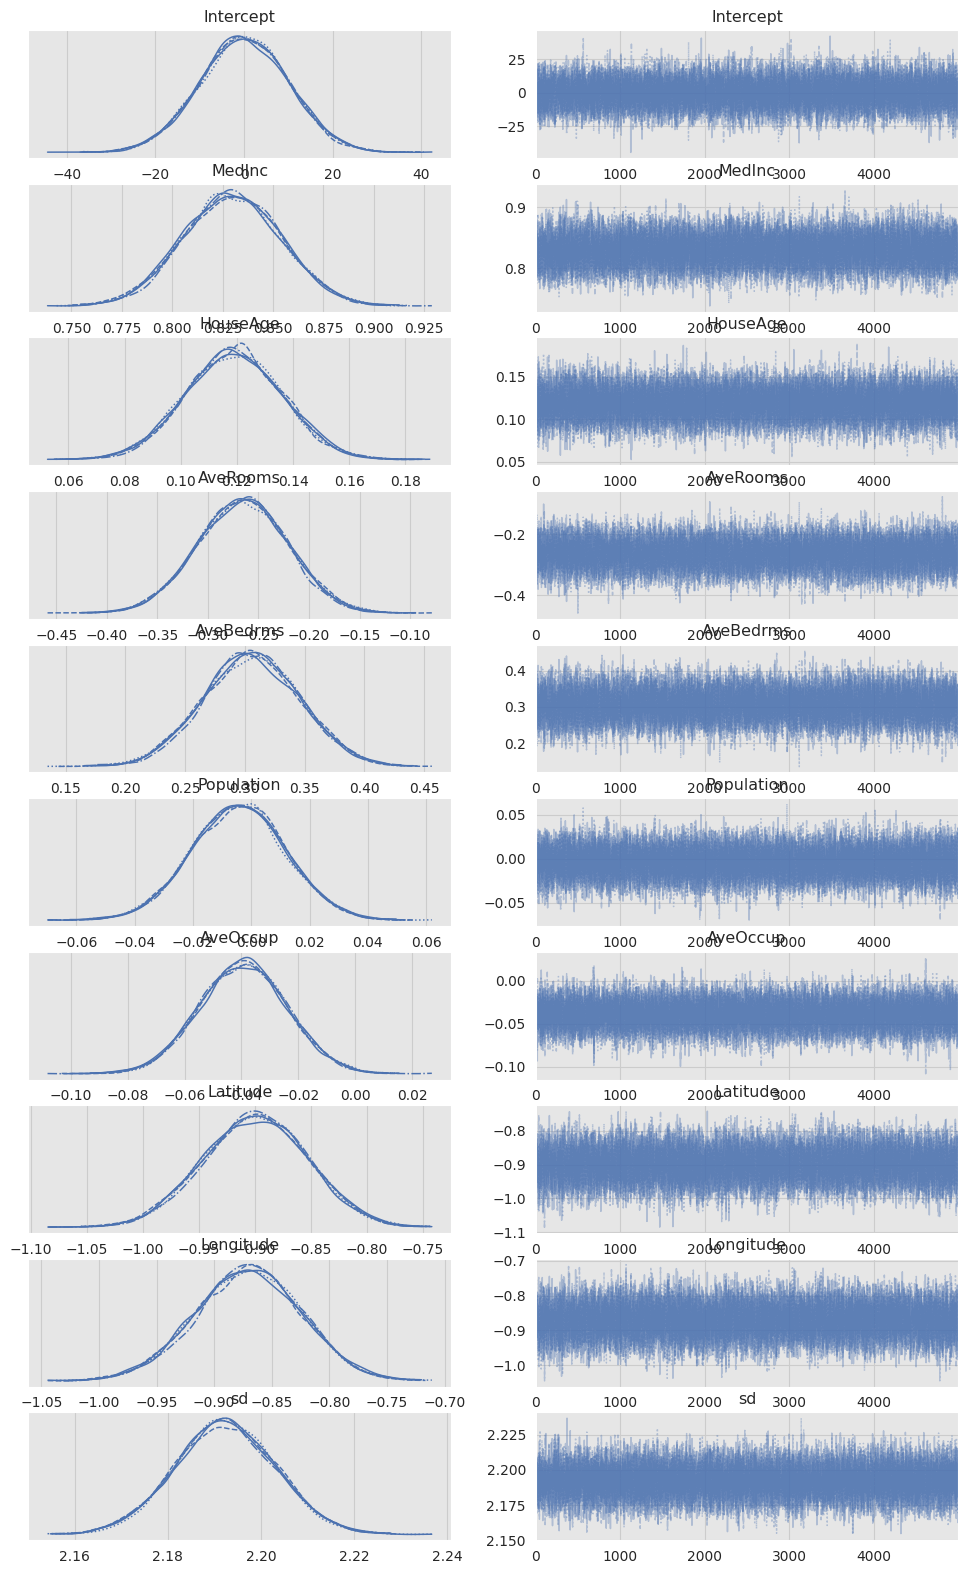

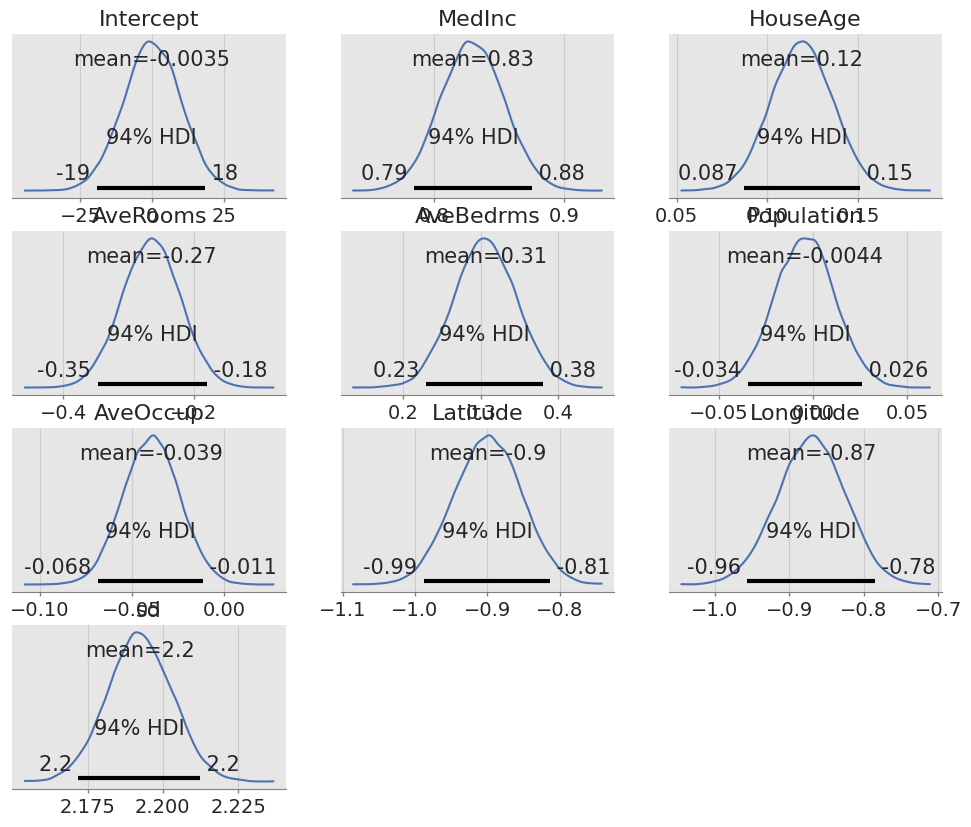

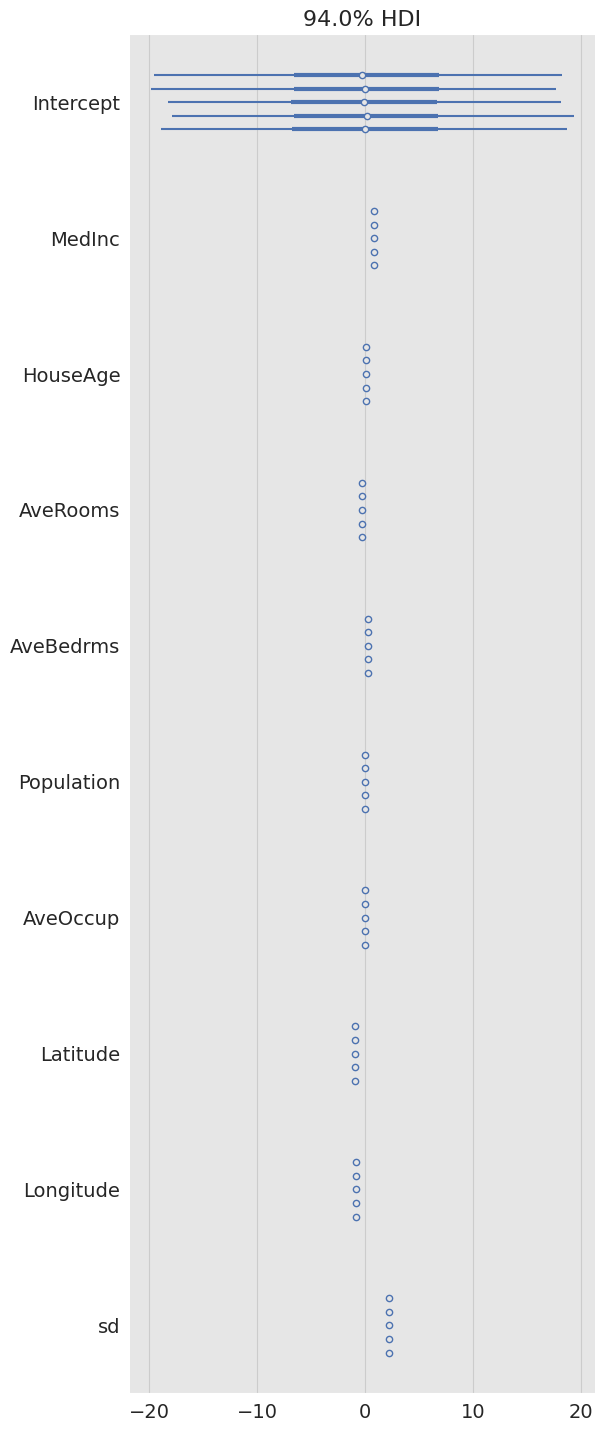

In [ ]:
formula="Price ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude"
family=pm.glm.families.Normal()
prior = {"Intercept": pm.Normal.dist(mu=0, sd=10),
        "x1": pm.Normal.dist(mu=0, sd=10),
        "x2": pm.Normal.dist(mu=0, sd=10),
        "x3": pm.Normal.dist(mu=0, sd=10),
        "x4": pm.Normal.dist(mu=0, sd=10),
        "x5": pm.Normal.dist(mu=0, sd=10),
        "x6": pm.Normal.dist(mu=0, sd=10),
        "x7": pm.Normal.dist(mu=0, sd=10),
        "x8": pm.Normal.dist(mu=0, sd=10),
        }
prior_samples=1000
draws=5000
chains=5 
tune=1000
target_accept=0.87 
SEED=12
test='No'

###
NUTS_fit(formula,df,test,family,prior,prior_samples,draws, chains, tune, target_accept, SEED,verbose=0)

## Model Inference using Variational Inference (mini-batch ADVI)
For the purposes of this demonstration, we allow 1,000 steps for each chain to converge to its steady-state and then sample for a further 5,000 steps - i.e. generate 5,000 samples from the posterior distribution, assuming that the chain has converged after 1,000 samples.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (5 chains in 1 job)
NUTS: [sd, Longitude, Latitude, AveOccup, Population, AveBedrms, AveRooms, HouseAge, MedInc, Intercept]


Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 553 seconds.


Finished [100%]: Average Loss = 45,577
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.097,7.446,-14.318,13.740,0.075,0.053,9752.0,10003.0,NaN
MedInc,0.832,0.017,0.801,0.864,0.000,0.000,10035.0,9613.0,NaN
HouseAge,0.118,0.017,0.085,0.149,0.000,0.000,10432.0,10137.0,NaN
AveRooms,-0.266,0.018,-0.298,-0.231,0.000,0.000,9511.0,10046.0,NaN
AveBedrms,0.306,0.018,0.273,0.340,0.000,0.000,9830.0,9677.0,NaN
Population,-0.005,0.017,-0.036,0.027,0.000,0.000,10084.0,10217.0,NaN
AveOccup,-0.037,0.017,-0.068,-0.005,0.000,0.000,8800.0,9621.0,NaN
Latitude,-0.900,0.018,-0.933,-0.865,0.000,0.000,9984.0,10050.0,NaN
Longitude,-0.871,0.018,-0.904,-0.837,0.000,0.000,9851.0,9715.0,NaN
sd,2.192,0.013,2.167,2.215,0.000,0.000,9984.0,9088.0,NaN


Training Fit


Got error No model on context stack. trying to find log_likelihood in translation.


mae= 2.0711126285344506
mse= 4.808967608198424
rmse= 2.192935842244005


Got error No model on context stack. trying to find log_likelihood in translation.


(<pymc3.model.Model at 0x7fb337416790>,
 <MultiTrace: 1 chains, 10000 iterations, 11 variables>)

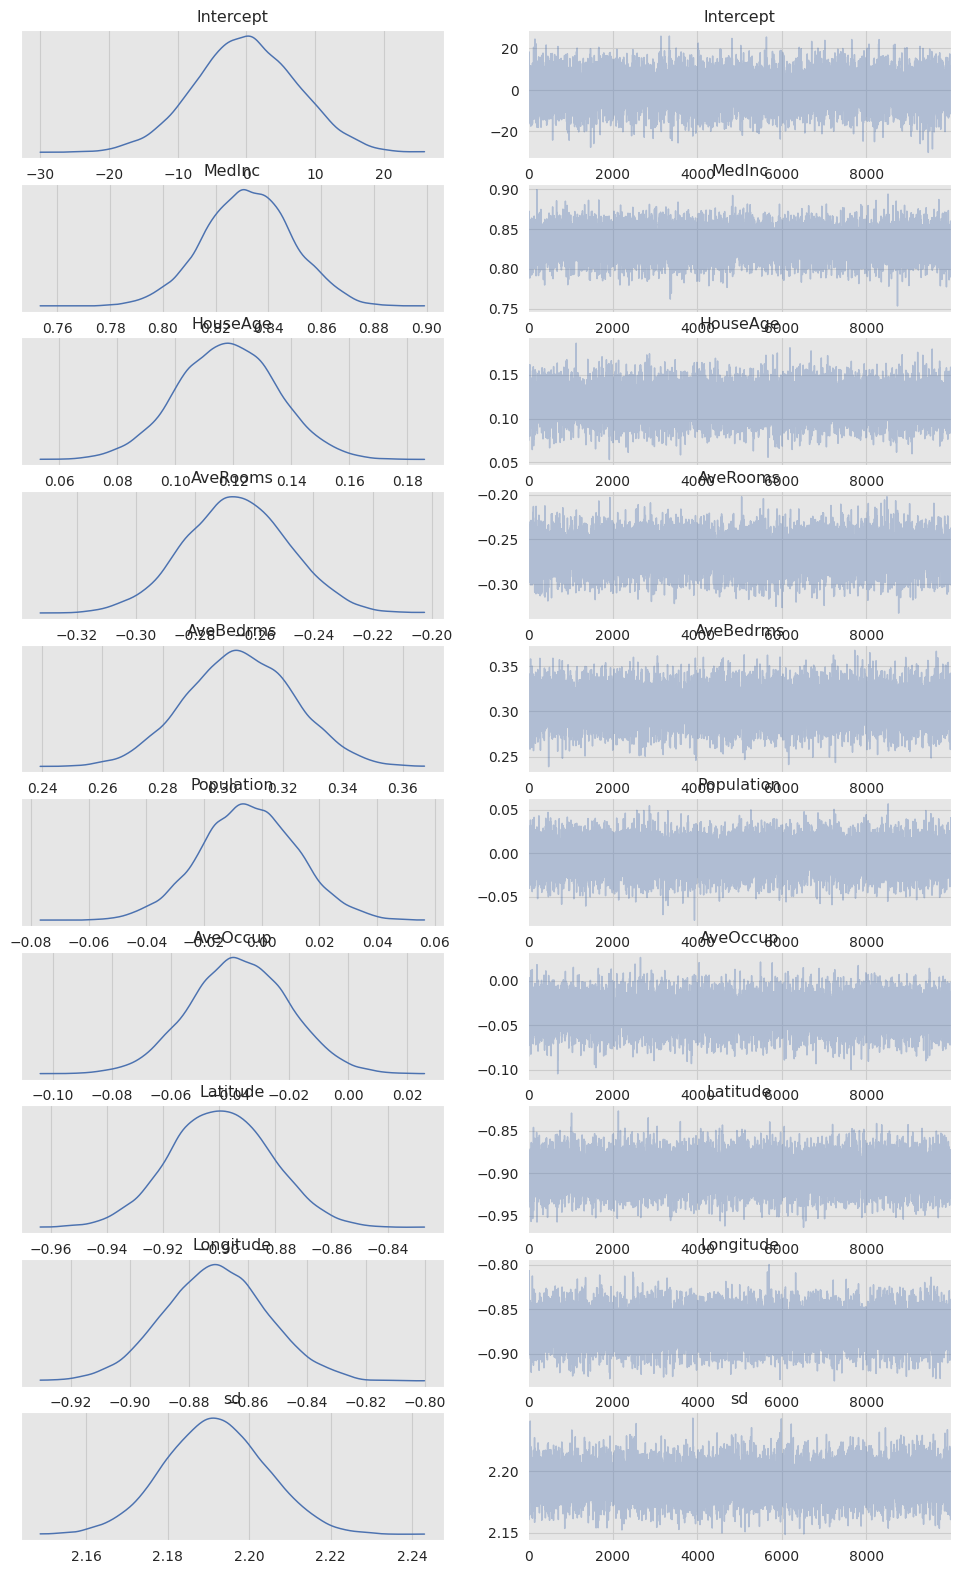

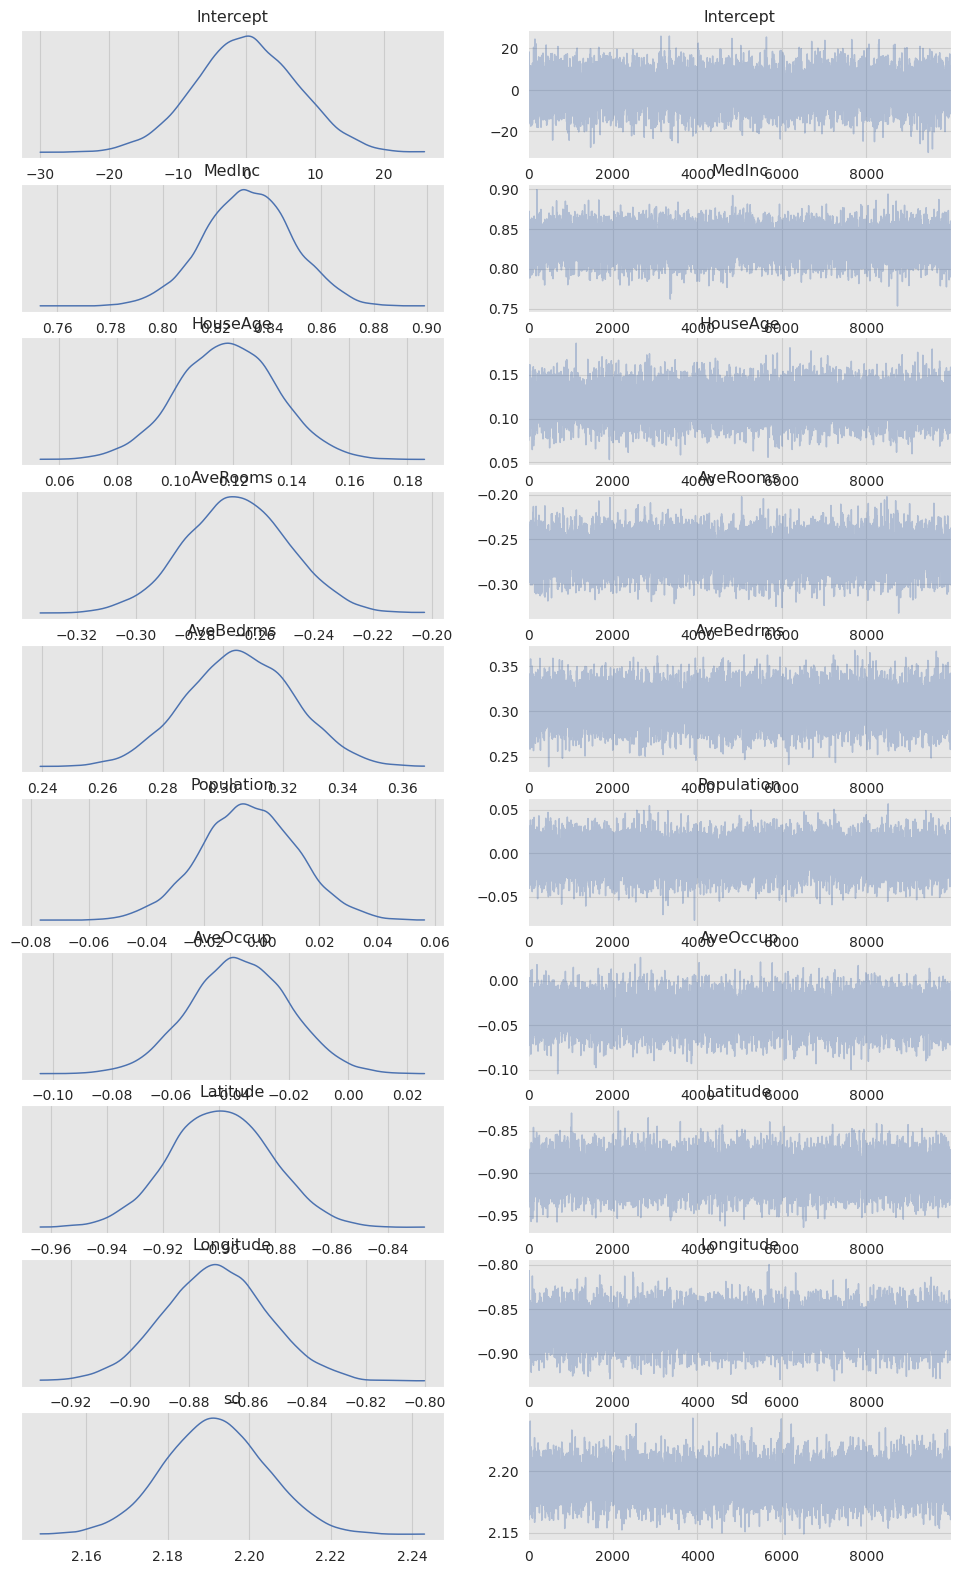

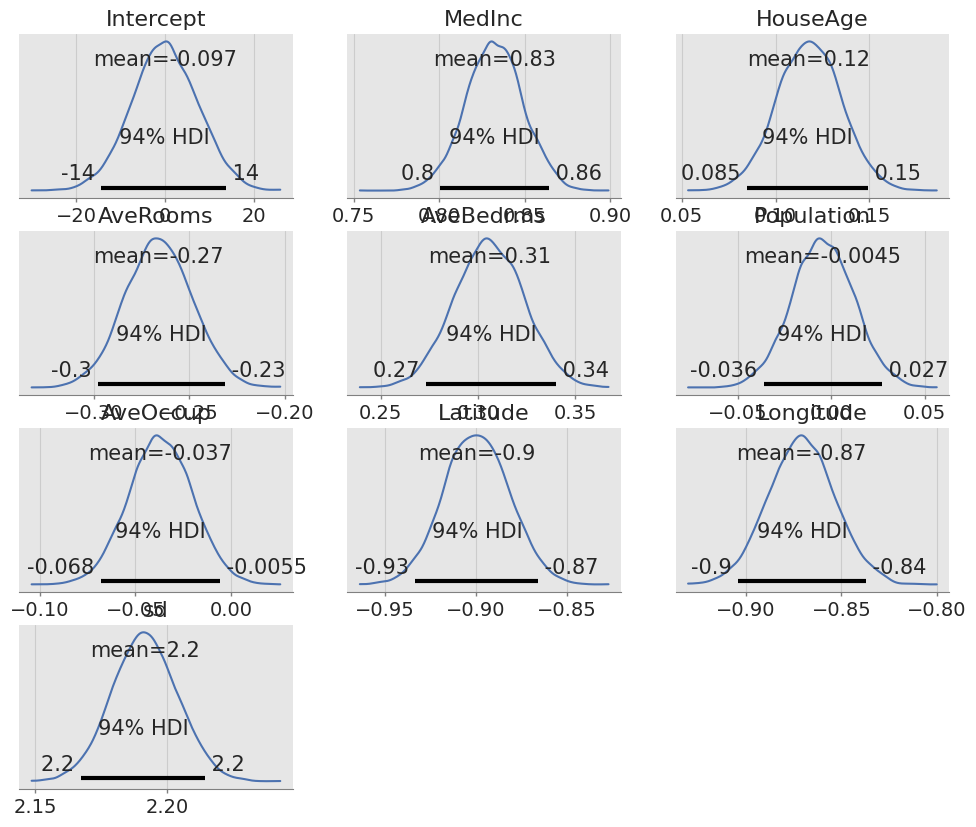

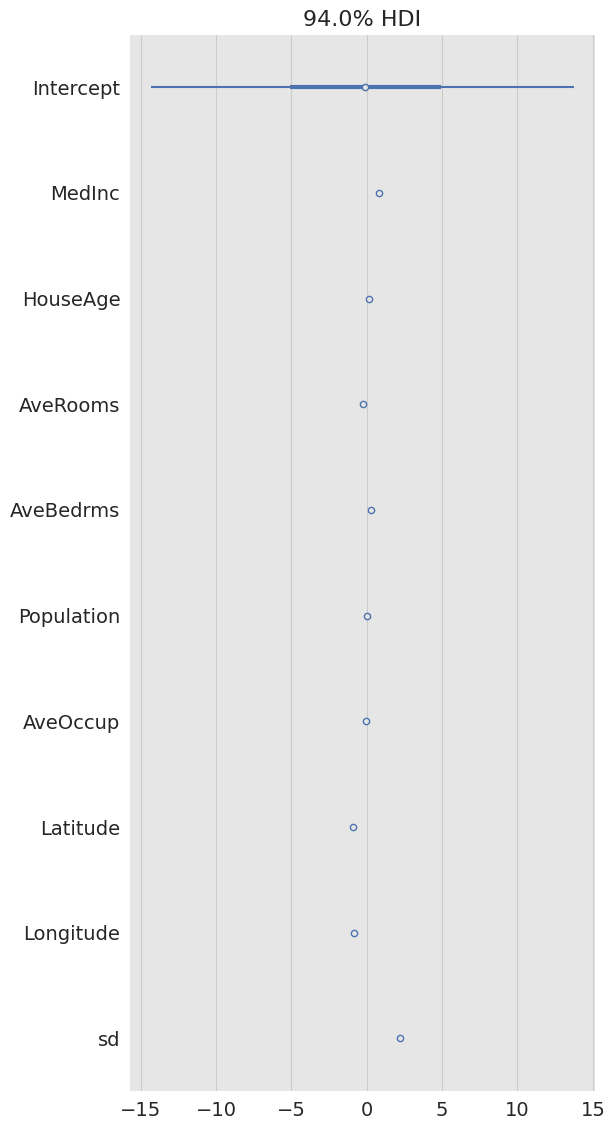

In [ ]:
formula="Price ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude"
family=pm.glm.families.Normal()
prior = {"Intercept": pm.Normal.dist(mu=0, sd=10),
        "x1": pm.Normal.dist(mu=0, sd=10),
        "x2": pm.Normal.dist(mu=0, sd=10),
        "x3": pm.Normal.dist(mu=0, sd=10),
        "x4": pm.Normal.dist(mu=0, sd=10),
        "x5": pm.Normal.dist(mu=0, sd=10),
        "x6": pm.Normal.dist(mu=0, sd=10),
        "x7": pm.Normal.dist(mu=0, sd=10),
        "x8": pm.Normal.dist(mu=0, sd=10),
        #"sd": pm.HalfNormal(mu=0, sd=10),
        }
prior_samples=1000
draws=5000
chains=5 
tune=1000
target_accept=0.87 
SEED=42
test='No'

###
ADVI_fit(formula,df,test,family,prior,prior_samples,draws, chains, tune, target_accept, SEED)

The results of above two frameworks show that
1. The Posterior distribution of estimators seems almost same, hwever the mean and standarad deviation (standard error) vary across the two MCMC setups. The priors are assumed same in both setups, but the posterior vary across two MCMC frameworks. 
2. The r-hat estimate in both setups is 1 across all 5 chains, indicating the convergence.
3. The fitting performance vary a bit between two as the residual discription show that

Residuals discription in Model Inference Using MCMC (HMC) 

mae= 2.0704017464747406

mse= 4.806544523776324

rmse= 2.1923832976412507

Residuals discription in Model Inference using Variational Inference (mini-batch ADVI)

mae= 2.0711126285344506

mse= 4.808967608198424

rmse= 2.192935842244005

Both setups show almost same performance.

# Comparing Predictions



In [ ]:
formula="Price ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude"
family=pm.glm.families.Normal()
prior = {"Intercept": pm.Normal.dist(mu=0, sd=10),
        "x1": pm.Normal.dist(mu=0, sd=10),
        "x2": pm.Normal.dist(mu=0, sd=10),
        "x3": pm.Normal.dist(mu=0, sd=10),
        "x4": pm.Normal.dist(mu=0, sd=10),
        "x5": pm.Normal.dist(mu=0, sd=10),
        "x6": pm.Normal.dist(mu=0, sd=10),
        "x7": pm.Normal.dist(mu=0, sd=10),
        "x8": pm.Normal.dist(mu=0, sd=10),
        #"sd": pm.HalfNormal(mu=0, sd=10),
        }
prior_samples=1000
draws=5000
chains=5 
tune=1000
target_accept=0.87 

SEED=42
test='yes'


NUTS_forecast(formula,df,test,family,prior,prior_samples, draws, chains, tune, target_accept, SEED)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (5 chains in 1 job)
NUTS: [sd, Longitude, Latitude, AveOccup, Population, AveBedrms, AveRooms, HouseAge, MedInc, Intercept]


Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 400 seconds.


mae= 2.073083710627684
mse= 4.820499608713962
rmse= 2.1955636198283943


(<pymc3.model.Model at 0x7f3fe587f990>,
 <MultiTrace: 5 chains, 5000 iterations, 11 variables>)

In [ ]:
formula="Price ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude"
family=pm.glm.families.Normal()
prior = {"Intercept": pm.Normal.dist(mu=0, sd=10),
        "x1": pm.Normal.dist(mu=0, sd=10),
        "x2": pm.Normal.dist(mu=0, sd=10),
        "x3": pm.Normal.dist(mu=0, sd=10),
        "x4": pm.Normal.dist(mu=0, sd=10),
        "x5": pm.Normal.dist(mu=0, sd=10),
        "x6": pm.Normal.dist(mu=0, sd=10),
        "x7": pm.Normal.dist(mu=0, sd=10),
        "x8": pm.Normal.dist(mu=0, sd=10),
        }
prior_samples=1000
draws=5000
chains=5 
tune=1000
target_accept=0.87 

SEED=42
test='yes'


ADVI_forecast(formula,df,test,family,prior,prior_samples, draws, chains, tune, target_accept, SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (5 chains in 1 job)
NUTS: [sd, Longitude, Latitude, AveOccup, Population, AveBedrms, AveRooms, HouseAge, MedInc, Intercept]


Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 450 seconds.


Finished [100%]: Average Loss = 31,929


Forecasting


mae= 2.073000326773149
mse= 4.819923265652235
rmse= 2.1954323641716305


(<pymc3.model.Model at 0x7fb341e3e5d0>,
 <MultiTrace: 1 chains, 10000 iterations, 11 variables>)

The results of prediction two frameworks show that
1. The r-hat estimate in both setups is 1 across all 5 chains, indicating the convergence.
3. The prediction performance vary a bit between two as the predictions errors discription show that

Prediction Errors discription in Model Inference Using MCMC (HMC) 

mae= 2.073083710627684

mse= 4.820499608713962

rmse= 2.1955636198283943

Prediction Errors discription in Model Inference using Variational Inference (mini-batch ADVI)

mae= 2.073000326773149

mse= 4.819923265652235

rmse= 2.1954323641716305

Both setups show almost same performance in terms of prediction.